# Liesel-GAM Demo Notebook

## Setup and Imports

In [26]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb
from liesel.contrib import splines
from smoothcon import SmoothCon

import liesel_gam as gam

In [27]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

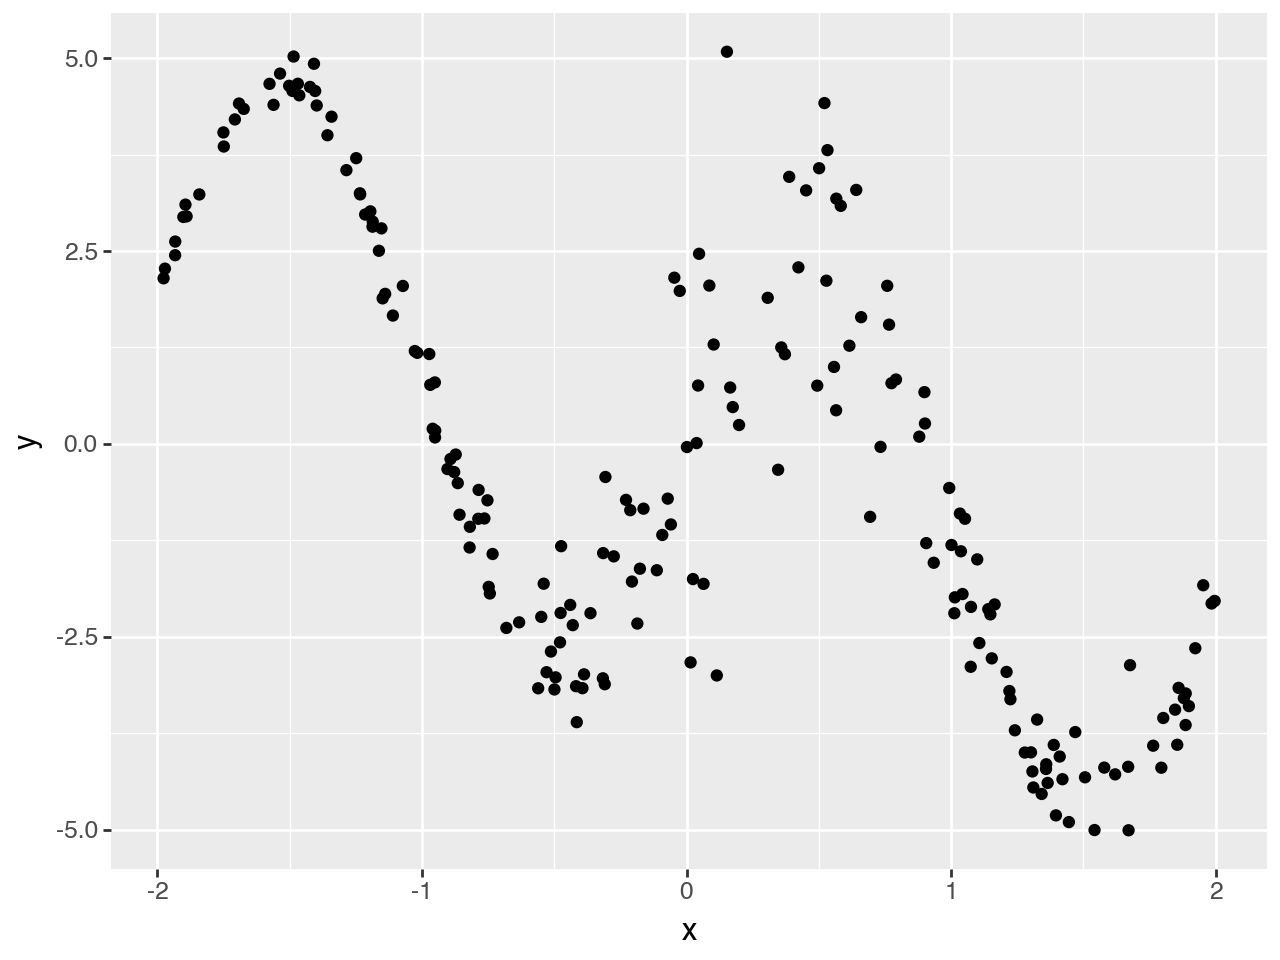

In [28]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

The `gam.AdditivePredictor()` objects are special `lsl.Var` classes. They allow users to add 
variables with the `+=` operator, and always represent the sum of all their inputs.
Thus, they conveniently represent additive predictors.

### Setup response model

In [29]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

### Set up intercepts

In [30]:
loc += gam.Intercept(name="$\\beta_0$", inference=gs.MCMCSpec(gs.IWLSKernel))
scale += gam.Intercept(name="$\\gamma_0$", inference=gs.MCMCSpec(gs.IWLSKernel))

### Set up basis an penalty matrices

Here, we pull the basis matrix and penalty from mgcv. Note that, using the 
`SmoothCon` class, you only need to execute Python code. No manual R call and 
convesion to Python objects necessary.

In [31]:
smooth_x = SmoothCon(
    # this string is the R code you *would* call in mgcv for this term
    spec="s(x, bs='ps', k=20, m=c(3,2))",
    data=df,
)

x_basis = gam.Basis(smooth_x.basis, name="B(x)")
penalty = smooth_x.penalty

### Initialize inverse smoothing parameters

Here, we initialize the inverse smoothing parameters. Setting it up like this allows us
to freely exchange their priors and/or their inference information, if we want or need
to.

In [32]:
m_x_tau2 = lsl.Var.new_param(
    value=1.0,
    distribution=lsl.Dist(tfd.InverseGamma, concentration=2.0, scale=0.5),
    name="$\\tau^2_m$",
)
m_x_tau = lsl.Var.new_calc(jnp.sqrt, m_x_tau2, name="$\\tau_m$")
m_x_tau2_log = m_x_tau2.transform(
    tfb.Exp(),
    name="$\\log \\tau^2_m$",  # New in liesel v0.4.0
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
)


s_x_tau2 = lsl.Var.new_param(
    1.0, lsl.Dist(tfd.InverseGamma, concentration=2.0, scale=0.5), name="$\\tau^2_s$"
)
s_x_tau = lsl.Var.new_calc(jnp.sqrt, s_x_tau2, name="$\\tau_s$")
s_x_tau2_log = s_x_tau2.transform(
    tfb.Exp(),
    name="$\\log \\tau^2_s$",  # New in liesel v0.4.0
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
)

### Initialize smooth terms

The `gam.SmoothTerm` can be used to represent isotropic smooths. It is a `lsl.Var` that
will automatically initialize a fitting coefficient variabel with a 
potentially singular multivariate normal prior given the penalty matrix.

In [33]:

loc += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="m(x)",
    variance_name="$\\tau^2_m$",
    coef_name="$\\beta$",  # I'm using LaTeX math syntax for pretty rendering in plots
)

scale += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="s(x)",
    variance_name="$\\tau^2_s$",
    coef_name="$\\gamma$",
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="B(x)_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


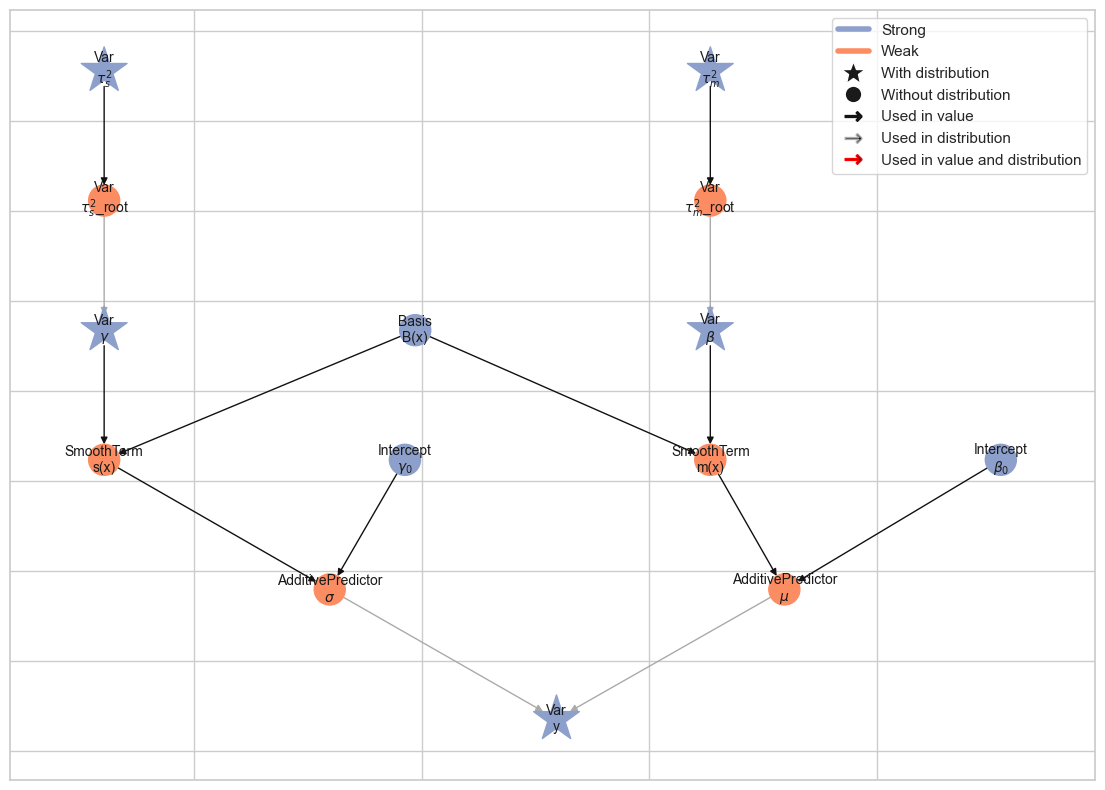

In [34]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [35]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\gamma$', '$\\tau^2_s$', '$\\gamma_0$', '$\\beta$', '$\\tau^2_m$', '$\\beta_0$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:04<00:00,  3.99chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 118.84chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 1, 0 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:0

### MCMC summary

In [36]:
summary = gs.Summary(results)
summary

Parameter summary:

                     kernel      mean        sd    q_0.05     q_0.5    q_0.95  \
parameter  index                                                                
$\beta$    (0,)   kernel_03  0.270740  0.449492 -0.441297  0.255148  1.030377   
           (1,)   kernel_03  0.002577  0.404919 -0.663038  0.003267  0.670203   
           (2,)   kernel_03  0.456897  0.432326 -0.200068  0.431355  1.222807   
           (3,)   kernel_03  0.191851  0.405597 -0.452671  0.180424  0.862257   
           (4,)   kernel_03  0.154653  0.368947 -0.437502  0.149140  0.772147   
           (5,)   kernel_03  0.158782  0.345816 -0.418112  0.151463  0.726286   
           (6,)   kernel_03 -0.026994  0.329910 -0.560725 -0.029967  0.511672   
           (7,)   kernel_03  0.079802  0.308258 -0.422681  0.082205  0.590622   
           (8,)   kernel_03  0.080319  0.299070 -0.385555  0.072163  0.572350   
           (9,)   kernel_03  0.121298  0.259066 -0.289706  0.116696  0.549727   
           (10,)  kernel_03  0.116170  0.250542 -0.295772  0.126225  0.511657   
           (11,)  kernel_03 -0.131827  0.211003 -0.475995 -0.132741  0.213427   
           (12,)  kernel_03  0.300934  0.188976 -0.019789  0.302710  0.599765   
           (13,)  kernel_03 -0.040151  0.146995 -0.277450 -0.040588  0.202474   
           (14,)  kernel_03  1.361134  0.114820  1.175264  1.357195  1.551492   
           (15,)  kernel_03 -0.042337  0.074199 -0.164308 -0.042530  0.077851   
           (16,)  kernel_03  0.124233  0.043359  0.055194  0.123383  0.195171   
           (17,)  kernel_03  0.015406  0.017630 -0.013737  0.015455  0.043917   
           (18,)  kernel_03 -0.309300  0.067654 -0.418457 -0.310394 -0.197216   
$\beta_0$  ()     kernel_05 -0.319187  0.060789 -0.417308 -0.319800 -0.216995   
$\gamma$   (0,)   kernel_00  0.015298  0.120513 -0.172529  0.010152  0.208637   
           (1,)   kernel_00  0.017357  0.119150 -0.165731  0.015343  0.210781   
           (2,)   kernel_00  0.003938  0.117954 -0.189642  0.004860  0.196995   
           (3,)   kernel_00  0.005782  0.114710 -0.179342  0.004774  0.194616   
           (4,)   kernel_00 -0.025691  0.118754 -0.220138 -0.021452  0.156179   
           (5,)   kernel_00  0.010460  0.112835 -0.173236  0.010436  0.191137   
           (6,)   kernel_00 -0.036191  0.116876 -0.231065 -0.031720  0.142967   
           (7,)   kernel_00  0.055737  0.111921 -0.113004  0.049804  0.246581   
           (8,)   kernel_00  0.039955  0.107276 -0.125838  0.034389  0.221214   
           (9,)   kernel_00  0.001889  0.098745 -0.162845  0.001036  0.166455   
           (10,)  kernel_00 -0.005122  0.092154 -0.153964 -0.006164  0.147349   
           (11,)  kernel_00  0.001010  0.088755 -0.143110 -0.001115  0.149645   
           (12,)  kernel_00  0.106412  0.085580 -0.023580  0.102328  0.253549   
           (13,)  kernel_00 -0.098084  0.074238 -0.225722 -0.096684  0.016421   
           (14,)  kernel_00  0.052667  0.060310 -0.046030  0.053064  0.151050   
           (15,)  kernel_00 -0.080525  0.044004 -0.151766 -0.080757 -0.008875   
           (16,)  kernel_00 -0.006306  0.026433 -0.048896 -0.006478  0.035621   
           (17,)  kernel_00 -0.044523  0.011549 -0.063336 -0.044502 -0.025290   
           (18,)  kernel_00  0.136487  0.044835  0.064847  0.136733  0.207352   
$\gamma_0$ ()     kernel_02 -0.634447  0.053420 -0.720238 -0.635526 -0.546305   
$\tau^2_m$ ()     kernel_04  0.245165  0.122909  0.111866  0.215243  0.480596   
$\tau^2_s$ ()     kernel_01  0.014002  0.011322  0.004307  0.010978  0.033628   

                  sample_size     ess_bulk     ess_tail      rhat  
parameter  index                                                   
$\beta$    (0,)          4000  3523.439649  3555.719038  1.000439  
           (1,)          4000  3417.930728  3916.027349  0.999977  
           (2,)          4000  3418.267331  3267.026381  1.000556  
           (3,)          4000  3089.997143  3454.260533  1.000886  
       

### MCMC trace plots

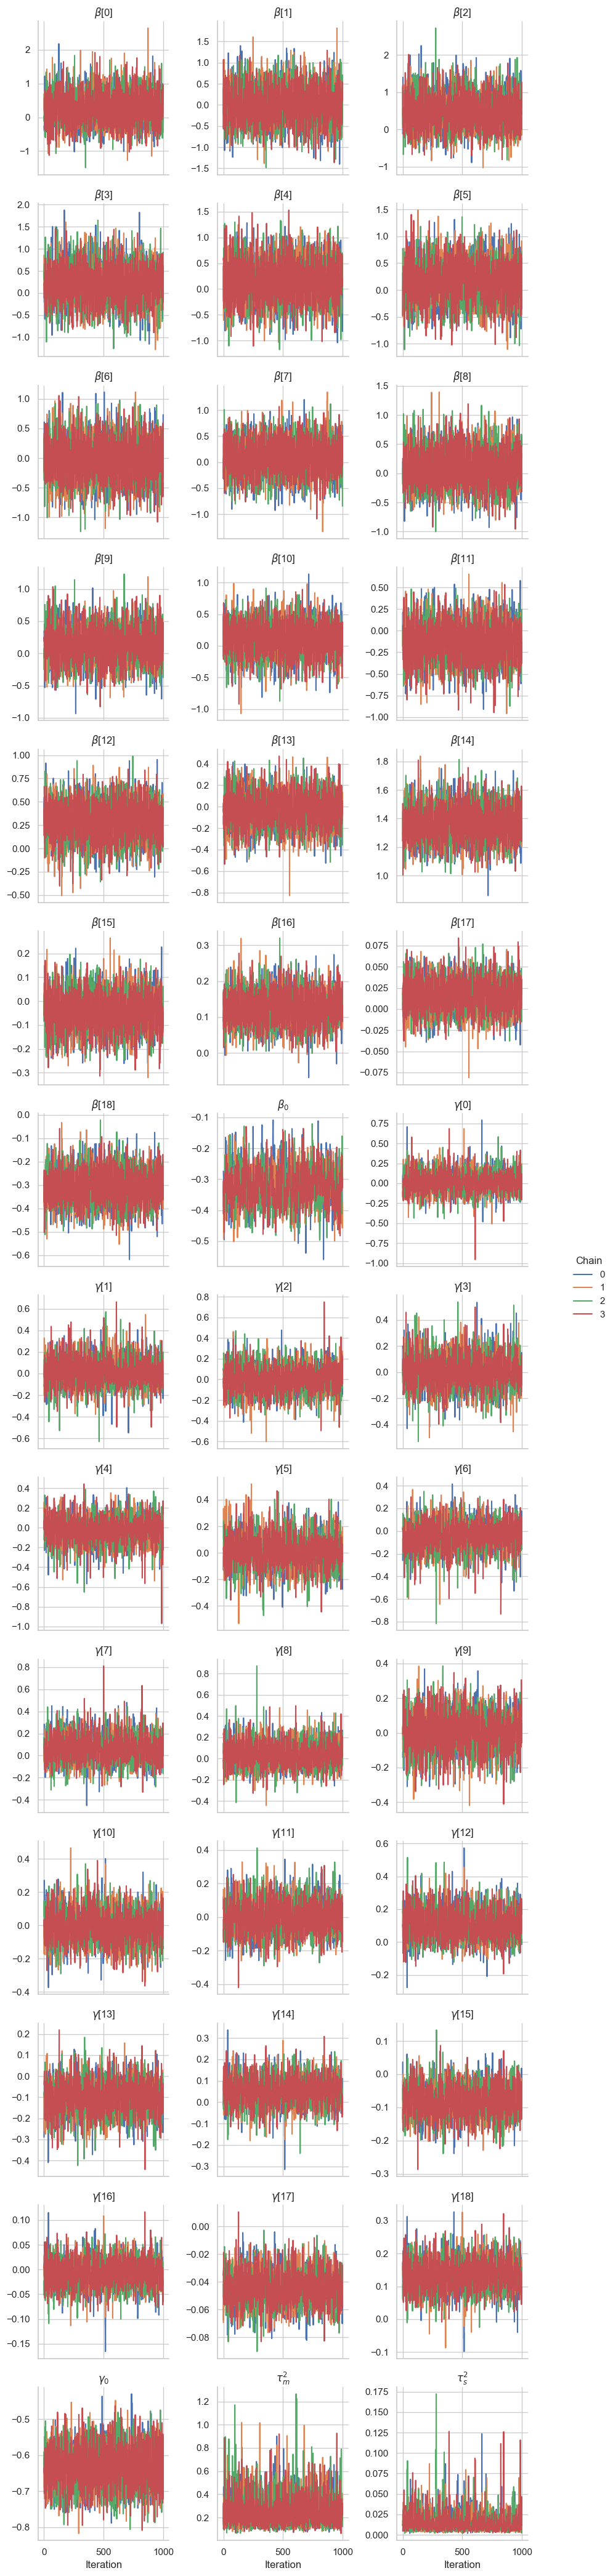

In [37]:
gs.plot_trace(results)

## Predictions

In [38]:
samples = results.get_posterior_samples()

### Evaluate basis matrix for new x values

We use the `SmoothCon` oject initialized above. This will internally call `mgcv`
to evaluate the basis matrix at the new x values, applying all the right reparameterizations 
automatically.

In [39]:
x_grid = jnp.linspace(x.min(), x.max(), 200)
B_x_grid = smooth_x.predict(data={"x": x_grid})

### Predict variables at new x values

In [40]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(x)", "s(x)", "$\\mu$", "$\\sigma$"],
    newdata={"B(x)": B_x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [41]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,2.188588,0.004086,0.063922,1.000292,3535.665708,3350.648007,0.001074,0.000956,2.087651,2.187170,2.293711,2.086873,2.291386,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,2.375260,0.002429,0.049280,1.000360,3492.125618,3439.089895,0.000836,0.000764,2.296150,2.374219,2.454224,2.295233,2.452023,-1.956738
2,$\mu$,$\mu$[2],"(2,)",4000,2.557331,0.001744,0.041764,1.000309,3360.764360,3684.634950,0.000720,0.000633,2.490364,2.557007,2.624023,2.489871,2.623324,-1.936774
3,$\mu$,$\mu$[3],"(3,)",4000,2.734442,0.001656,0.040688,1.000078,3316.799849,3746.435985,0.000705,0.000576,2.667850,2.734795,2.800938,2.671837,2.804387,-1.916810
4,$\mu$,$\mu$[4],"(4,)",4000,2.906226,0.001888,0.043454,0.999977,3353.553103,3440.829750,0.000749,0.000580,2.834035,2.907055,2.976163,2.833856,2.975807,-1.896846


### Plot fitted functions

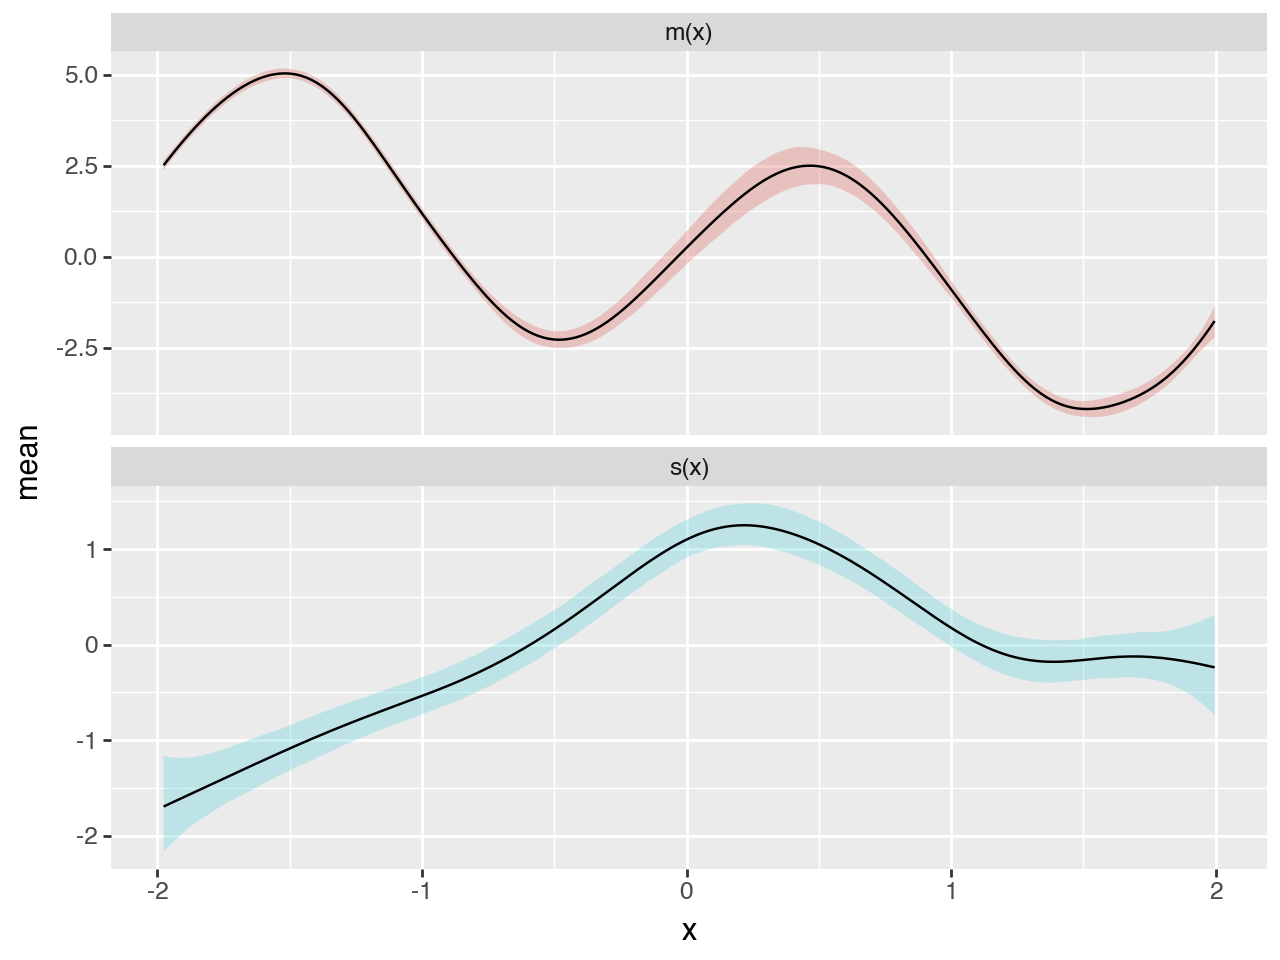

In [42]:
select = predictions_summary["variable"].isin(["s(x)", "m(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

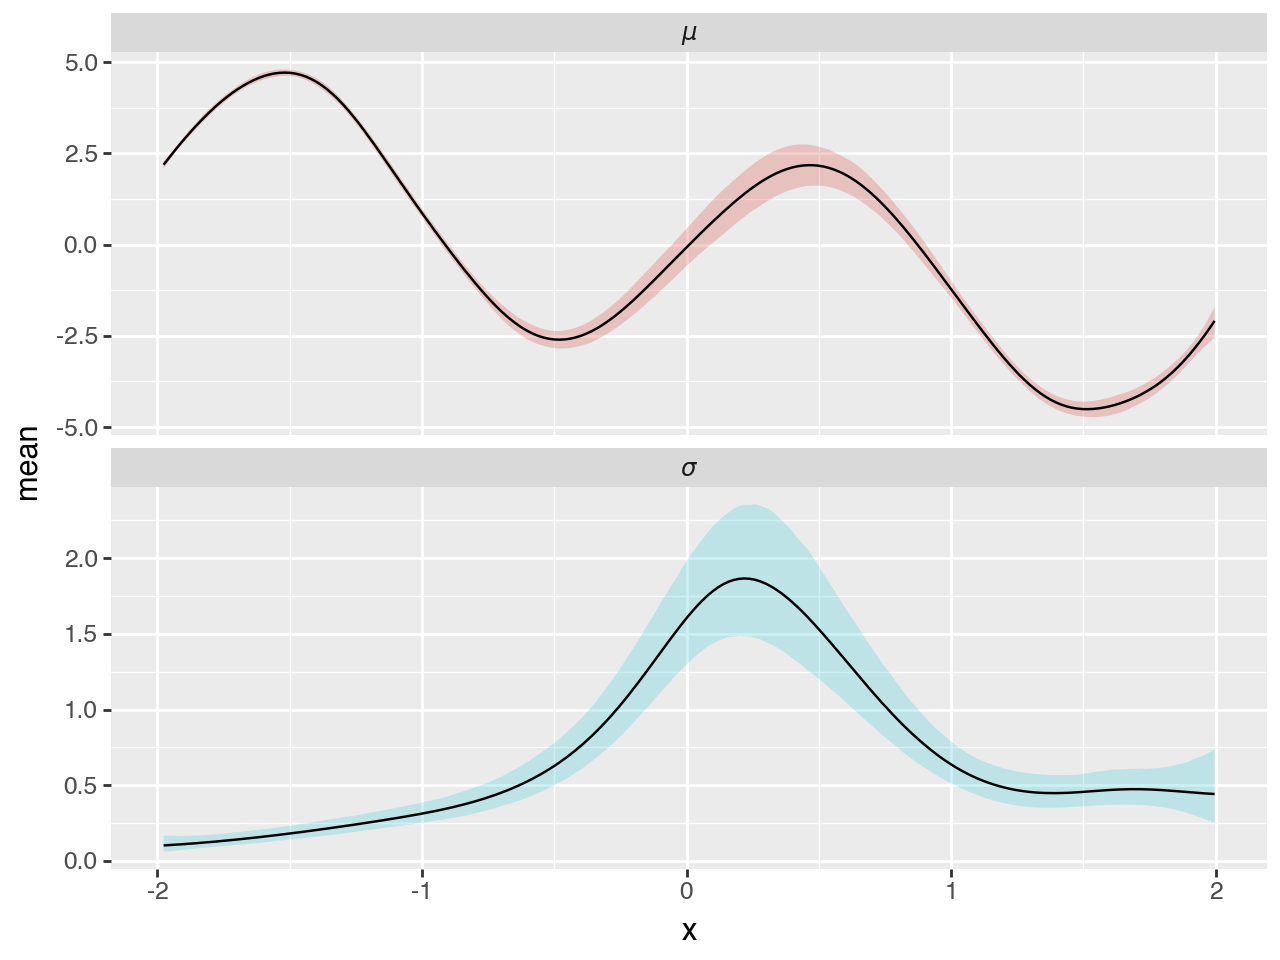

In [43]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

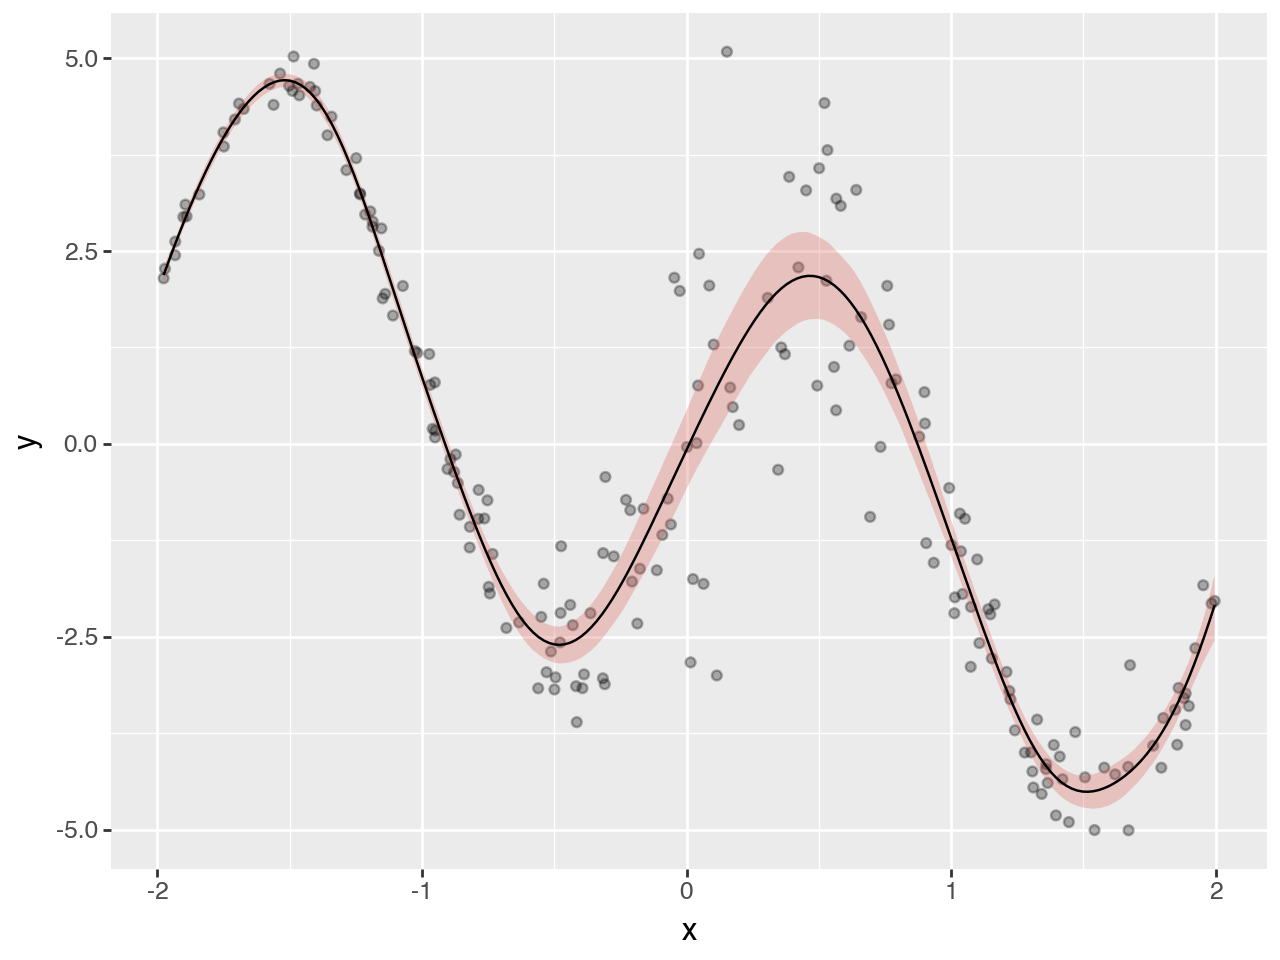

In [44]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [45]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,2.188588,0.102741,2.085847,2.291329
1,-1.956738,2.375260,0.104740,2.270519,2.480000
2,-1.936774,2.557331,0.106884,2.450447,2.664214
3,-1.916810,2.734442,0.109166,2.625276,2.843608
4,-1.896846,2.906226,0.111582,2.794644,3.017807
...,...,...,...,...,...
195,1.916248,-2.878616,0.451944,-3.330560,-2.426672
196,1.936212,-2.696228,0.449175,-3.145404,-2.247053
197,1.956176,-2.503545,0.446589,-2.950133,-2.056956
198,1.976140,-2.301119,0.444262,-2.745381,-1.856857


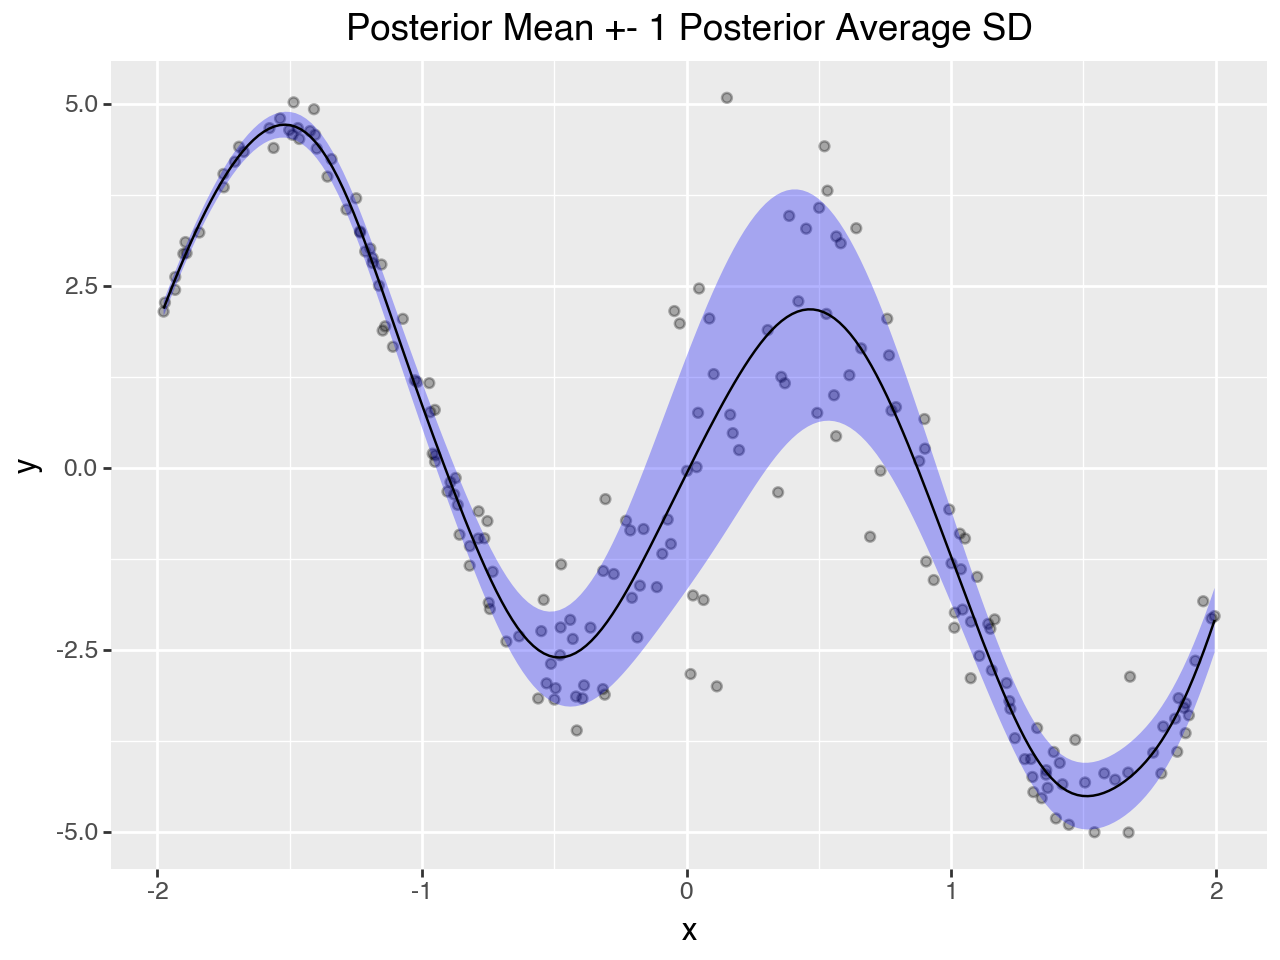

In [46]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [47]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [48]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [49]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

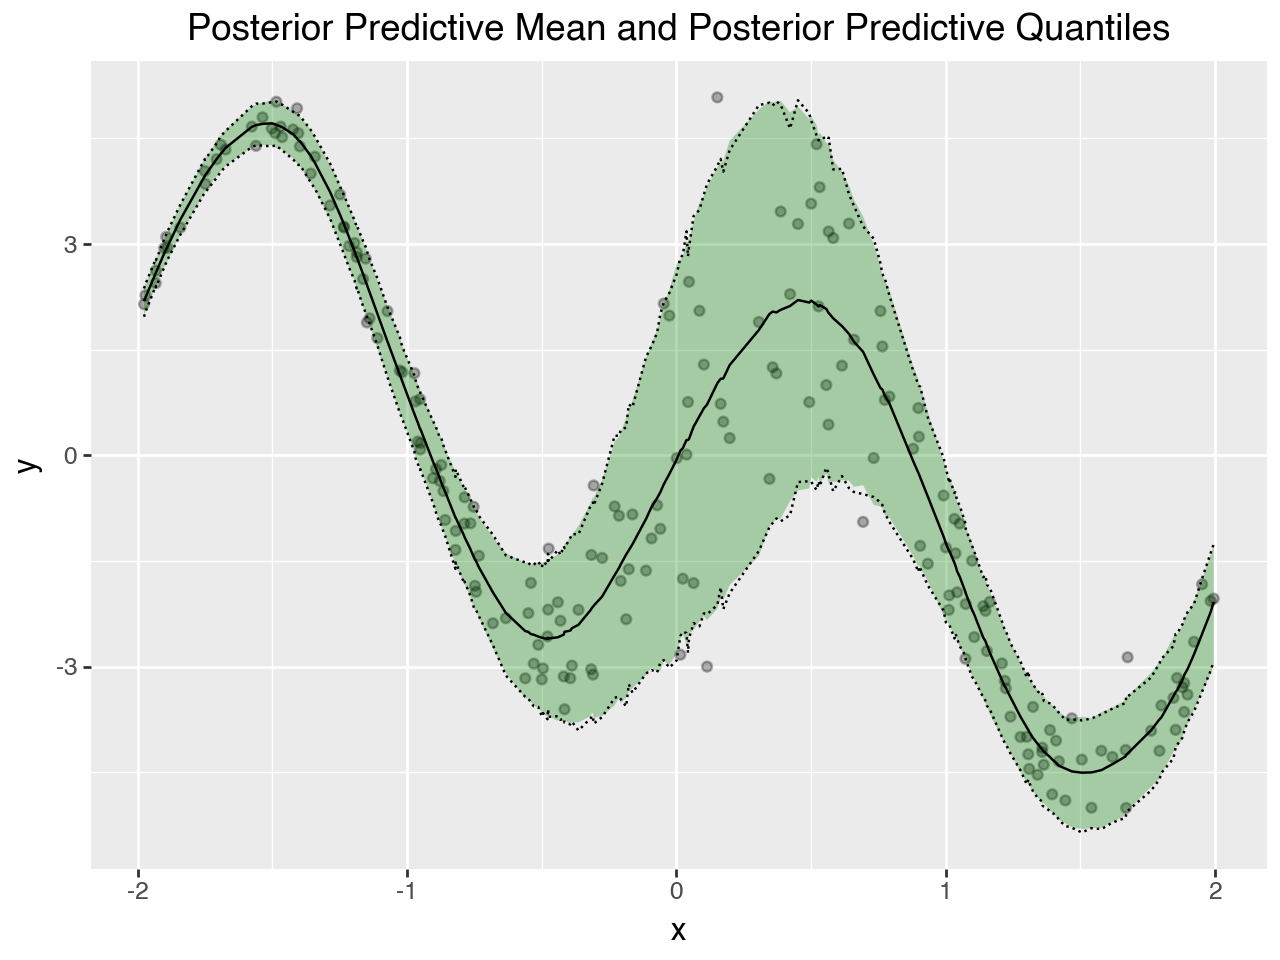

In [50]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

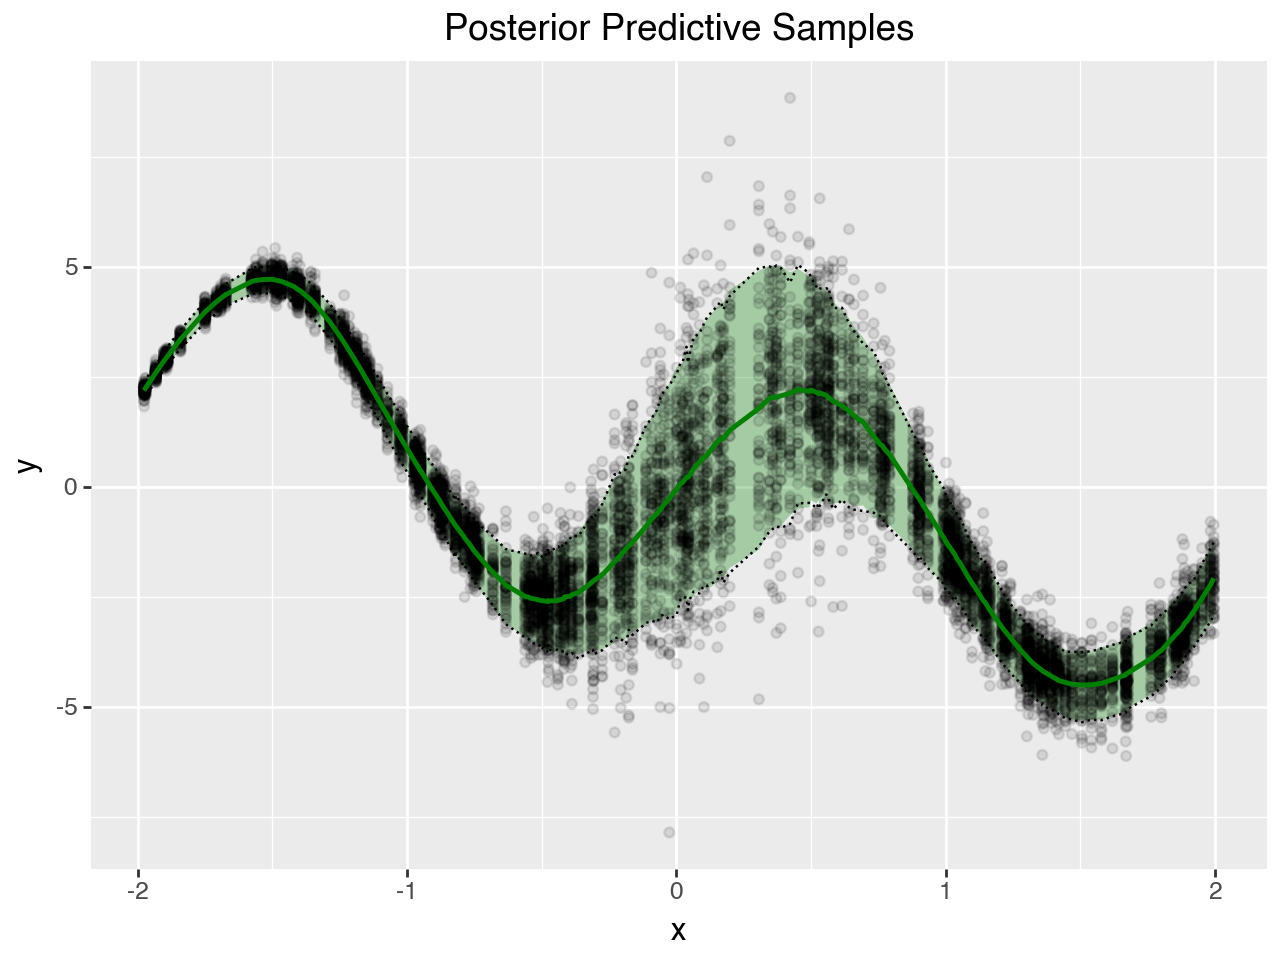

In [51]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)